In [5]:
import numpy as np
import os

import geopandas as gpd
import pandas as pd
import pickle
import sklearn
import matplotlib.pyplot as plt
import urllib.request

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel

In [6]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world.to_crs(df.crs)

# for i in sorted(df['month_id'].unique())[300:305]:

#     print(f"{i}: {df[df['month_id'] == i]['year_months_start'].unique().item()}")
#     fig, ax = plt.subplots(figsize = (20,20))
#     df[df['month_id'] == i].plot(ax=ax, column = 'log_best')
#     world.plot(facecolor='none', edgecolor='black', ax=ax)
#     plt.show()

## get relevant area

In [7]:
def get_cshapes():
    location = '/home/simon/Documents/Bodies/data/PRIO' 
    path_cshapes = location + "/CShapes-2.0.csv"
    
    if os.path.isfile(path_cshapes) == True:
        print('file already downloaded')
        cshapes = pd.read_csv(path_cshapes)


    else: 
        print('Beginning file download CShapes...')

        url_cshapes = 'https://icr.ethz.ch/data/cshapes/CShapes-2.0.csv'
    
        urllib.request.urlretrieve(url_cshapes, path_cshapes)
        cshapes = pd.read_csv(path_cshapes)

    return cshapes

In [8]:
def get_sub_df():
    
    data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

    with open(f'{data_dir}g_df_ucdp_prio.pkl', 'rb') as file:
        df = pickle.load(file)

    cshapes = get_cshapes()
    cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
    gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()
    df_sub = df[df['gwno'].isin(gwno_to_keep)].copy()

    return df_sub

In [9]:
df = get_sub_df()

file already downloaded


In [10]:
print(f"{df['year'].min()},{df['year'].max()}")
print(12 * (df['year'].max() - df['year'].min()))
print(df.groupby('gid').count()['month_id'].unique()) # every gid should have 360 month ids....)

1989,2019
360
[372]


In [12]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
# sub_world = world[world['name'].isin(country_mask_world)].copy()


# for i in sorted(df['month_id'].unique())[180:185]:

#     print(f"{i}: {df[df['month_id'] == i]['year_months_start'].unique().item()}")

#     fig, ax = plt.subplots(figsize = (20,20))

#     ax.set_aspect('equal')

#     vmax = combined_df['log_best'].max()
#     vmax = df.loc[df['month_id'].isin(np.arange(180, 185+1, 1)), 'log_best'].max()

#     df[df['month_id'] == i].plot(ax = ax, column = 'log_best', cmap = 'rainbow', vmin = 0, vmax = vmax)
#     sub_world.plot(facecolor='none', edgecolor='black', ax=ax)
#     plt.show()

# estimate GP

In [13]:
def esstimate_kernel(df_sub):
    
    test_gids = df_sub.loc[df_sub['log_best'] > 6, 'gid'].unique()
    n_timelines = test_gids.shape[0]

    print(f'number of timelines used: {n_timelines}')

    mask = df_sub['gid'].isin(test_gids)
    df_test2 = df_sub[mask].copy()
    df_test2.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work

    y = np.array(df_test2['log_best']).reshape(-1, n_timelines)
    x = np.array(df_test2[['month_id']]).reshape(-1, n_timelines)

    # GP
    noise_std = y.std()

    kernel_short = ConstantKernel() * Matern(length_scale=4.0, length_scale_bounds=(1, 32.0), nu=1.5) # nu = 1.5 gives v = 3/2 so matern32
    kernel_long = ConstantKernel() * RBF(length_scale=20.0, length_scale_bounds=(32, 320))

    kernel =  kernel_short + kernel_long + WhiteKernel(noise_level=noise_std)

    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    gaussian_process.fit(x, y)
    gaussian_process.kernel_

    return gaussian_process.kernel_

### You need a better kritaria here.

In [14]:
kernel = esstimate_kernel(df)
print(kernel)

# lock kernel
kernel.set_params(k1__k1__k1__constant_value_bounds = 'fixed', 
                  k1__k1__k2__length_scale_bounds = 'fixed', 
                  k1__k2__k1__constant_value_bounds = 'fixed', 
                  k1__k2__k2__length_scale_bounds = 'fixed', 
                  k2__noise_level_bounds = 'fixed' )

number of timelines used: 43
0.541**2 * Matern(length_scale=26.7, nu=1.5) + 1.35**2 * RBF(length_scale=234) + WhiteKernel(noise_level=0.398)


0.541**2 * Matern(length_scale=26.7, nu=1.5) + 1.35**2 * RBF(length_scale=234) + WhiteKernel(noise_level=0.398)

In [15]:
def predict_gp(df):
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    n_timelines_new = df['gid'].unique().shape[0]
    df.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work
    x_new = np.array(df[['month_id']]).reshape(-1, n_timelines_new)
    y_new = np.array(df[['log_best']]).reshape(-1, n_timelines_new)

    gaussian_process.fit(x_new,y_new) #this refit is only needed bacouse you have more timelines here and treat them aas features...
    print(gaussian_process.kernel_)
    mean_prediction, std_prediction = gaussian_process.predict(x_new, return_std=True)

    return(mean_prediction, std_prediction)

In [16]:
mean_prediction, std_prediction = predict_gp(df)

df['tce'] = mean_prediction.reshape(-1,1)
df['tce_std'] = std_prediction.reshape(-1,1)

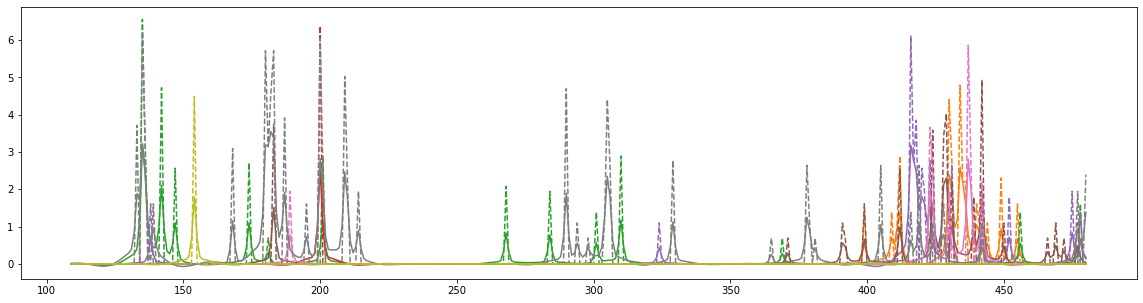

In [46]:
plot_gids = np.random.choice(df.loc[df['log_best'] > 4, 'gid'].unique(), 8)
plt.figure(figsize =  [20,5])

for i, gid in enumerate(plot_gids):

    c = f'C{i+1}'

    timeline = df.loc[df['gid'] == gid, ['month_id', 'log_best', 'tce']]

    plt.plot(timeline['month_id'],timeline['log_best'], '--', c = c)
    plt.plot(timeline['month_id'],timeline['tce'], c = c)

plt.show()

289: 2004-01


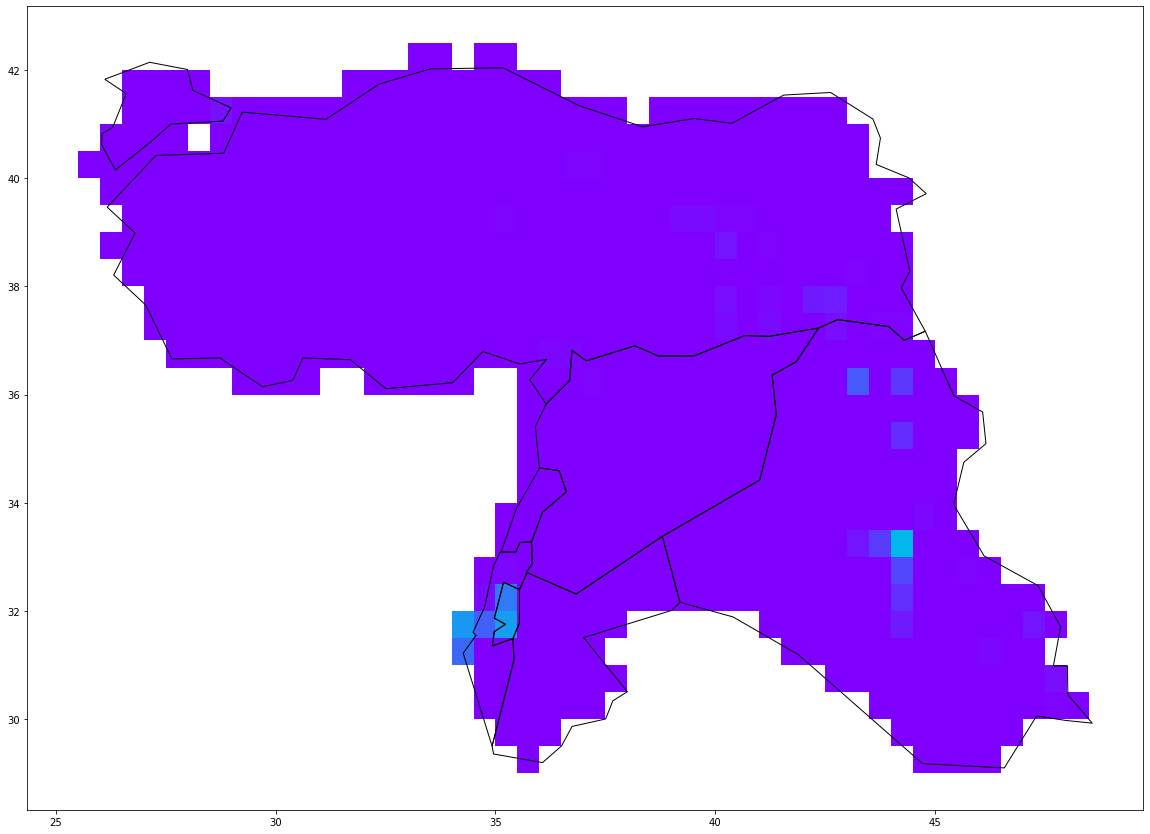

290: 2004-02


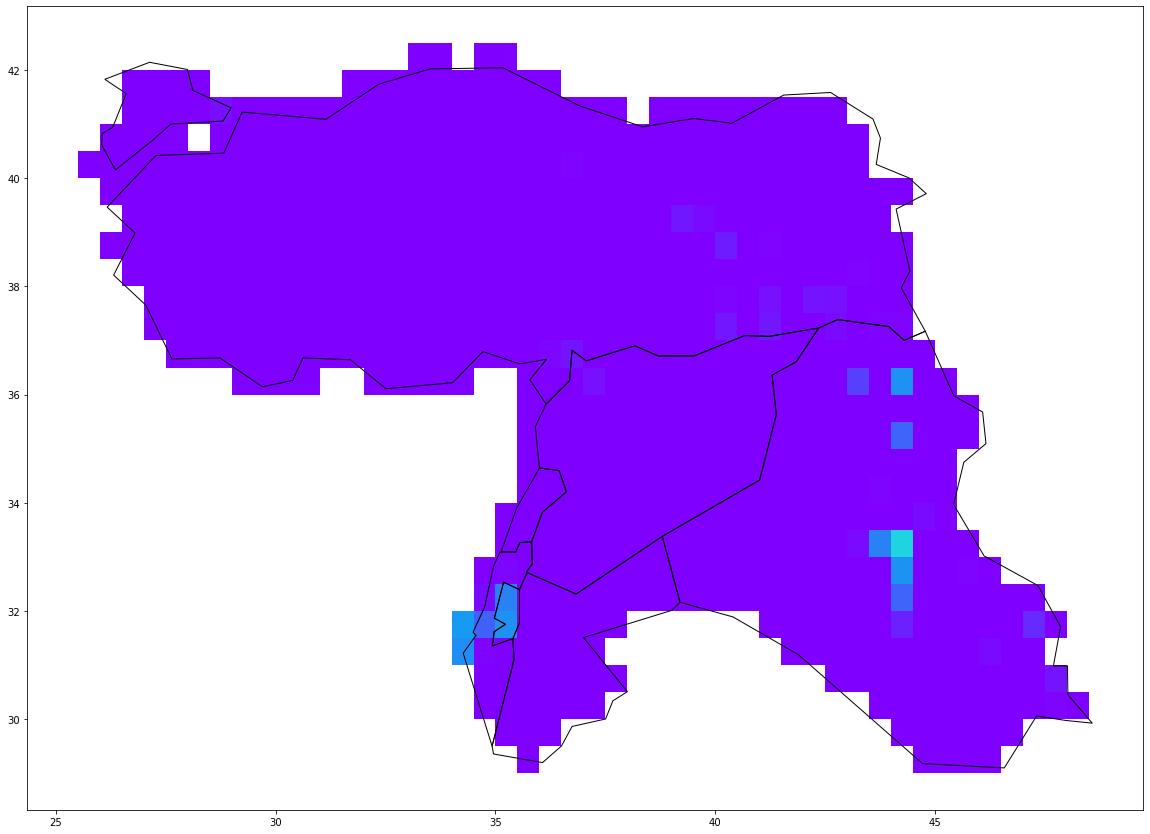

291: 2004-03


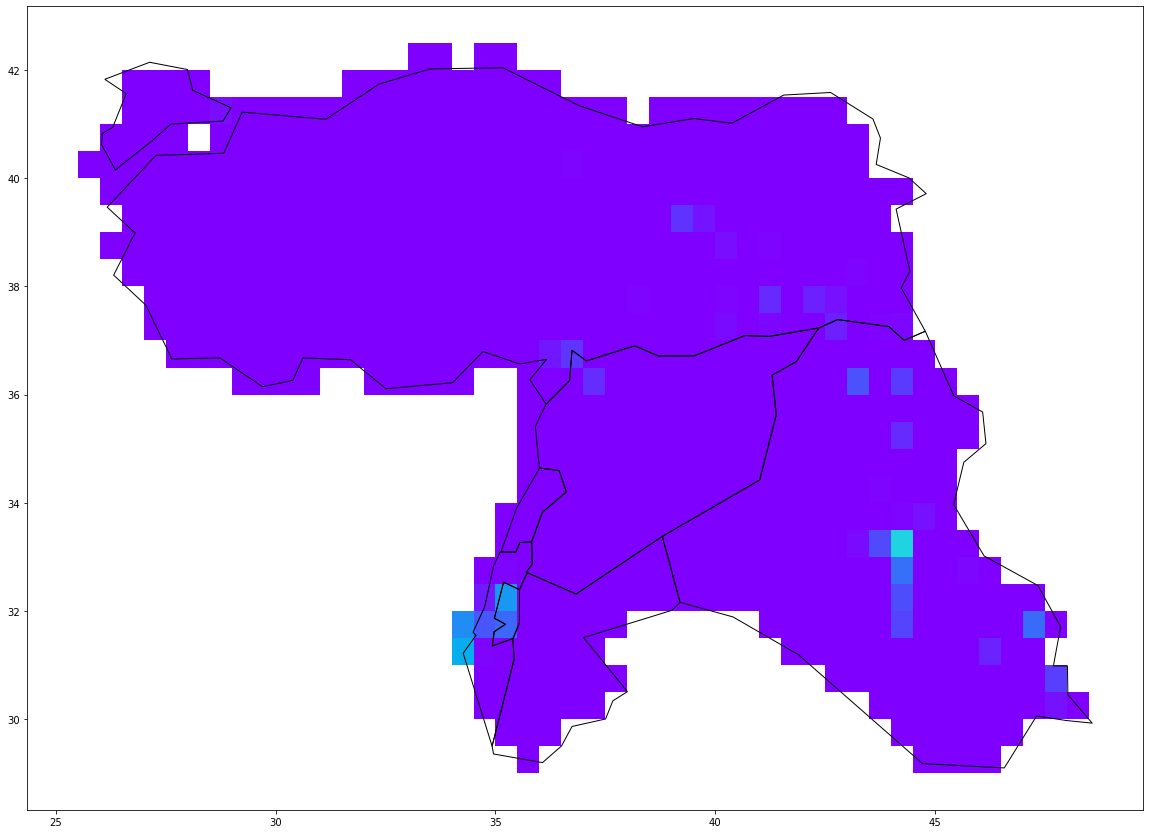

292: 2004-04


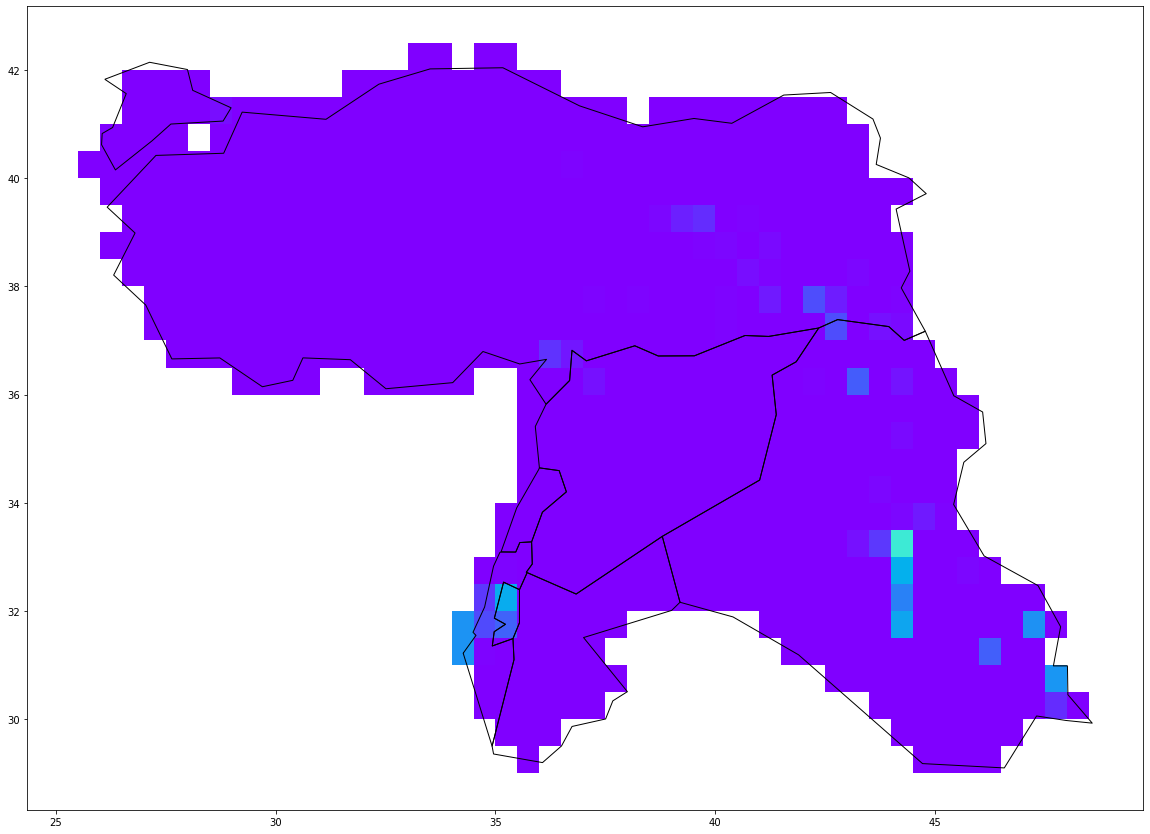

293: 2004-05


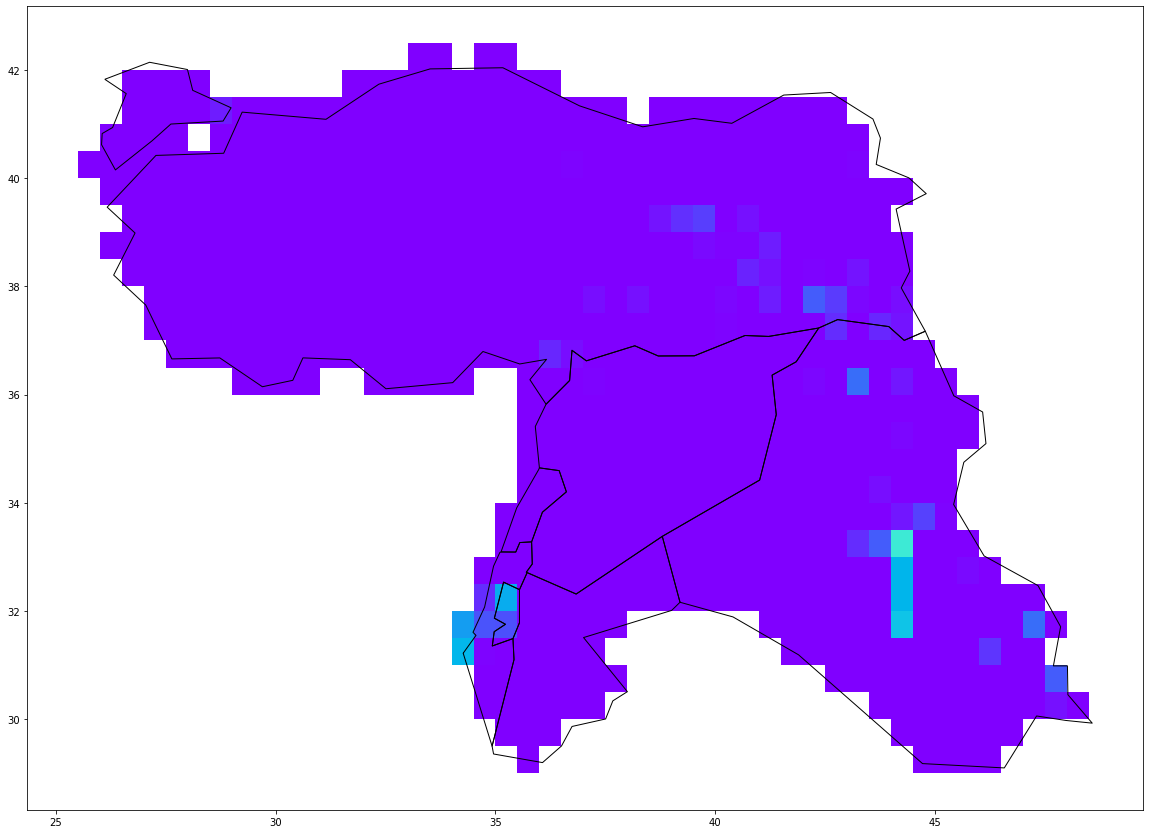

In [50]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()

for i in sorted(df['month_id'].unique())[180:185]:

    print(f"{i}: {df[df['month_id'] == i]['year_months_start'].unique().item()}")

    fig, ax = plt.subplots(figsize = (20,20))

    ax.set_aspect('equal')

    #vmax = combined_df['log_best'].max()
    vmax = df.loc[:,'log_best'].max()

    df[df['month_id'] == i].plot(ax = ax, column = 'tce', cmap = 'rainbow', vmin = 0, vmax = vmax)
    sub_world.plot(facecolor='none', edgecolor='black', ax=ax)
    plt.show()

# Spatial

Damn... Should you just estimate a sample (5) with som amount of conflict and then just use fixed hps from those... Sound like a bette plan

In [80]:
sub_months = df[df['log_best'] > 4].groupby('month_id').count().sort_values('gid', ascending = False).iloc[:60,:].sample(5).index.values

In [81]:
noise_std = df['tce'].std()
kernel = ConstantKernel() * Matern(length_scale=0.5, length_scale_bounds=(0.1, 4.0), nu=1.5) + WhiteKernel(noise_level=noise_std)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

for month_id in sub_months:
    df_month = df[df['month_id'] == month_id].copy()
    y = np.array(df_month['tce']).reshape(-1,1)
    X = np.array(df_month[['xcoord', 'ycoord']]).reshape(-1,2)
    
    gaussian_process.fit(X, y)
    print(gaussian_process.kernel_)

0.667**2 * Matern(length_scale=0.782, nu=1.5) + WhiteKernel(noise_level=0.245)
0.731**2 * Matern(length_scale=1.18, nu=1.5) + WhiteKernel(noise_level=0.494)
0.582**2 * Matern(length_scale=1.03, nu=1.5) + WhiteKernel(noise_level=0.282)
0.846**2 * Matern(length_scale=1.05, nu=1.5) + WhiteKernel(noise_level=0.434)
0.774**2 * Matern(length_scale=1.09, nu=1.5) + WhiteKernel(noise_level=0.451)


In [89]:
gaussian_process.kernel_.get_params()

{'k1': 0.774**2 * Matern(length_scale=1.09, nu=1.5),
 'k2': WhiteKernel(noise_level=0.451),
 'k1__k1': 0.774**2,
 'k1__k2': Matern(length_scale=1.09, nu=1.5),
 'k1__k1__constant_value': 0.5988662177416193,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 1.0886627970973508,
 'k1__k2__length_scale_bounds': (0.1, 4.0),
 'k1__k2__nu': 1.5,
 'k2__noise_level': 0.45051735321026154,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

### Alright, try switching to pymc3... for now just hardcode something
be a bitch ass renegade and estimate hps in pytorch just to run it in scikit learn - no regrets YOLO!!!

In [130]:
amplitude = ConstantKernel(constant_value = 0.7**2, constant_value_bounds = 'fixed')
matern =  Matern(length_scale=0.5, nu=1.5, length_scale_bounds = 'fixed')
epsilon = WhiteKernel(noise_level=0.4, noise_level_bounds = 'fixed')

kernel = amplitude * matern + epsilon

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

mean_prediction_list = []
std_prediction_list = []
gid_list = [] # for easy merge
month_id_list = [] # for easy merge
xcoord_list = []
ycoord_list = []
tce_list = []

for month_id in df['month_id'].unique():
    df_month = df[df['month_id'] == month_id].copy()
    y = np.array(df_month['tce']).reshape(-1,1)
    X = np.array(df_month[['xcoord', 'ycoord']]).reshape(-1,2)
    
    gaussian_process.fit(X, y)
    print(gaussian_process.kernel_)
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

    mean_prediction_list.append(mean_prediction)
    std_prediction_list.append(std_prediction)
    gid_list.append(np.array(df_month['gid']))
    month_id_list.append(np.array(df_month['month_id']))
    xcoord_list.append(np.array(df_month['xcoord']))
    ycoord_list.append(np.array(df_month['ycoord']))
    tce_list.append(np.array(df_month['tce']))


0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.4)
0.7**2 * Matern(length_scale=0.5, nu=1.5) + WhiteKe

In [131]:
tsce_df = pd.DataFrame({'tsce':np.array(mean_prediction_list).ravel(), 
                        'tsce_std':np.array(std_prediction_list).ravel(), 
                        'gid':np.array(gid_list).ravel(), 
                        'month_id':np.array(month_id_list).ravel(),
                        'xcoord':np.array(xcoord_list).ravel(),
                        'ycoord': np.array(ycoord_list).ravel(),
                        'tce': np.array(tce_list).ravel()})

In [132]:
tsce_df

,tsce,tsce_std,gid,month_id,xcoord,ycoord,tce
0,1.373556e-05,0.776208,171792,109,35.75,29.25,0.0
1,-2.342031e-06,0.769859,171810,109,44.75,29.25,0.0
2,-3.699799e-06,0.763475,171811,109,45.25,29.25,0.0
3,-8.068320e-06,0.763475,171812,109,45.75,29.25,0.0
4,-1.615749e-05,0.769859,171813,109,46.25,29.25,0.0
...,...,...,...,...,...,...,...
246631,-2.352073e-07,0.769804,189793,480,36.25,41.75,0.0
246632,4.675537e-06,0.769832,190507,480,33.25,42.25,0.0
246633,-6.852354e-08,0.769522,190508,480,33.75,42.25,0.0
246634,-5.877168e-08,0.769522,190510,480,34.75,42.25,0.0


In [ ]:
for month_id in tsce_df['month_id'].unique():
    month_tsce_df = tsce_df[tsce_df['month_id'] == month_id]

    plt.figure(figsize = [14,8])
    plt.scatter(month_tsce_df['xcoord'], month_tsce_df['ycoord'], c =  month_tsce_df['tsce'], cmap = 'rainbow', marker = 's', s = 235, vmin = 0, vmax =  month_tsce_df['tsce'].max())
    plt.show()

In [ ]:
tsce_df

In [135]:
df_exposure = df.merge(tsce_df, how = 'left', on = ['gid', 'month_id', 'xcoord', 'ycoord', 'tce'])

In [136]:
df_exposure

,gid,xcoord,ycoord,col,row,geometry,year,gwno,month,year_months_start,...,best,low,high,log_best,log_low,log_high,tce,tce_std,tsce,tsce_std
0,171792,35.75,29.25,432,239,"POLYGON ((35.50000 29.00000, 35.50000 29.50000...",1989,663.0,01,1989-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780673,1.373556e-05,0.776208
1,171810,44.75,29.25,450,239,"POLYGON ((44.50000 29.00000, 44.50000 29.50000...",1989,645.0,01,1989-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780673,-2.342031e-06,0.769859
2,171811,45.25,29.25,451,239,"POLYGON ((45.00000 29.00000, 45.00000 29.50000...",1989,645.0,01,1989-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780673,-3.699799e-06,0.763475
3,171812,45.75,29.25,452,239,"POLYGON ((45.50000 29.00000, 45.50000 29.50000...",1989,645.0,01,1989-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780673,-8.068320e-06,0.763475
4,171813,46.25,29.25,453,239,"POLYGON ((46.00000 29.00000, 46.00000 29.50000...",1989,645.0,01,1989-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780673,-1.615749e-05,0.769859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246631,189793,36.25,41.75,433,264,"POLYGON ((36.00000 41.50000, 36.00000 42.00000...",2019,640.0,12,2019-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780673,-2.352073e-07,0.769804
246632,190507,33.25,42.25,427,265,"POLYGON ((33.00000 42.00000, 33.00000 42.50000...",2019,640.0,12,2019-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780673,4.675537e-06,0.769832
246633,190508,33.75,42.25,428,265,"POLYGON ((33.50000 42.00000, 33.50000 42.50000...",2019,640.0,12,2019-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780673,-6.852354e-08,0.769522
246634,190510,34.75,42.25,430,265,"POLYGON ((34.50000 42.00000, 34.50000 42.50000...",2019,640.0,12,2019-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780673,-5.877168e-08,0.769522


In [137]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'
with open(f'{data_dir}df_exposure.pkl', 'wb') as file:
    pickle.dump(df_exposure, file)
            

# OLD

In [132]:
mean_prediction_list = []
std_prediction_list = []
gid_list = [] # for easy merge
month_id_list = [] # for easy merge
xcoord_list = []
ycoord_list = []
tce_list = []

noise_std = df_sub['tce'].std()
kernel = ConstantKernel() * Matern(length_scale=0.5, length_scale_bounds=(0.1, 4.0), nu=1.5) + WhiteKernel(noise_level=noise_std)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

for month_id in df_sub['month_id'].unique():
    df_month = df_sub[df_sub['month_id'] == month_id].copy()
    y = np.array(df_month['tce']).reshape(-1,1)
    X = np.array(df_month[['xcoord', 'ycoord']]).reshape(-1,2)
    
    gaussian_process.fit(X, y)
    print(gaussian_process.kernel_)
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

    mean_prediction_list.append(mean_prediction)
    std_prediction_list.append(std_prediction)
    gid_list.append(np.array(df_month['gid']))
    month_id_list.append(np.array(df_month['month_id']))
    xcoord_list.append(np.array(df_month['xcoord']))
    ycoord_list.append(np.array(df_month['ycoord']))
    tce_list.append(np.array(df_month['tce']))
# 510min

0.204**2 * Matern(length_scale=0.546, nu=1.5) + WhiteKernel(noise_level=0.0105)
0.133**2 * Matern(length_scale=0.619, nu=1.5) + WhiteKernel(noise_level=0.0165)
0.124**2 * Matern(length_scale=0.473, nu=1.5) + WhiteKernel(noise_level=0.0194)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.196**2 * Matern(length_scale=0.28, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.219**2 * Matern(length_scale=0.336, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.204**2 * Matern(length_scale=0.353, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.208**2 * Matern(length_scale=0.337, nu=1.5) + WhiteKernel(noise_level=0.00196)
0.175**2 * Matern(length_scale=0.433, nu=1.5) + WhiteKernel(noise_level=0.0207)
0.17**2 * Matern(length_scale=0.364, nu=1.5) + WhiteKernel(noise_level=0.00842)
0.0977**2 * Matern(length_scale=0.829, nu=1.5) + WhiteKernel(noise_level=0.0166)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.162**2 * Matern(length_scale=0.36, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.199**2 * Matern(length_scale=0.354, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.214**2 * Matern(length_scale=0.317, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.167**2 * Matern(length_scale=0.472, nu=1.5) + WhiteKernel(noise_level=0.0202)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.212**2 * Matern(length_scale=0.297, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.196**2 * Matern(length_scale=0.288, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.185**2 * Matern(length_scale=0.309, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.116**2 * Matern(length_scale=0.723, nu=1.5) + WhiteKernel(noise_level=0.0183)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.175**2 * Matern(length_scale=0.41, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.0954**2 * Matern(length_scale=0.779, nu=1.5) + WhiteKernel(noise_level=0.00904)
0.126**2 * Matern(length_scale=0.459, nu=1.5) + WhiteKernel(noise_level=0.00365)
0.104**2 * Matern(length_scale=0.496, nu=1.5) + WhiteKernel(noise_level=0.012)
0.119**2 * Matern(length_scale=0.376, nu=1.5) + WhiteKernel(noise_level=4.09e-05)
0.106**2 * Matern(length_scale=0.59, nu=1.5) + WhiteKernel(noise_level=0.0133)
0.14**2 * Matern(length_scale=0.861, nu=1.5) + WhiteKernel(noise_level=0.075)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.3**2 * Matern(length_scale=0.282, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.119**2 * Matern(length_scale=1.77, nu=1.5) + WhiteKernel(noise_level=0.0749)
0.118**2 * Matern(length_scale=1.86, nu=1.5) + WhiteKernel(noise_level=0.0474)
0.088**2 * Matern(length_scale=1.23, nu=1.5) + WhiteKernel(noise_level=0.0275)
0.105**2 * Matern(length_scale=0.62, nu=1.5) + WhiteKernel(noise_level=0.00979)
0.102**2 * Matern(length_scale=1.16, nu=1.5) + WhiteKernel(noise_level=0.0238)
0.08**2 * Matern(length_scale=1.32, nu=1.5) + WhiteKernel(noise_level=0.0163)
0.0789**2 * Matern(length_scale=1.22, nu=1.5) + WhiteKernel(noise_level=0.016)
0.0903**2 * Matern(length_scale=1.32, nu=1.5) + WhiteKernel(noise_level=0.023)
0.0891**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=0.0146)
0.0881**2 * Matern(length_scale=0.964, nu=1.5) + WhiteKernel(noise_level=0.0145)
0.115**2 * Matern(length_scale=0.69, nu=1.5) + WhiteKernel(noise_level=0.0083)
0.114**2 * Matern(length_scale=0.943, nu=1.5) + WhiteK

/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.189**2 * Matern(length_scale=0.386, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.105**2 * Matern(length_scale=1.15, nu=1.5) + WhiteKernel(noise_level=0.0244)
0.125**2 * Matern(length_scale=1.26, nu=1.5) + WhiteKernel(noise_level=0.0289)
0.13**2 * Matern(length_scale=1.1, nu=1.5) + WhiteKernel(noise_level=0.0221)
0.156**2 * Matern(length_scale=0.796, nu=1.5) + WhiteKernel(noise_level=0.0264)
0.183**2 * Matern(length_scale=0.874, nu=1.5) + WhiteKernel(noise_level=0.0249)
0.182**2 * Matern(length_scale=1.19, nu=1.5) + WhiteKernel(noise_level=0.031)
0.164**2 * Matern(length_scale=1.5, nu=1.5) + WhiteKernel(noise_level=0.0357)
0.131**2 * Matern(length_scale=1.54, nu=1.5) + WhiteKernel(noise_level=0.0278)
0.0894**2 * Matern(length_scale=1.61, nu=1.5) + WhiteKernel(noise_level=0.0233)
0.0524**2 * Matern(length_scale=1.64, nu=1.5) + WhiteKernel(noise_level=0.0117)
0.05**2 * Matern(length_scale=1.29, nu=1.5) + WhiteKernel(noise_level=0.015)
0.0522**2 * Matern(length_scale=0.982, nu=1.5) + White

/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.0862**2 * Matern(length_scale=0.369, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.0809**2 * Matern(length_scale=0.385, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.0629**2 * Matern(length_scale=0.789, nu=1.5) + WhiteKernel(noise_level=0.00779)
0.0559**2 * Matern(length_scale=0.685, nu=1.5) + WhiteKernel(noise_level=0.00604)
0.0444**2 * Matern(length_scale=0.98, nu=1.5) + WhiteKernel(noise_level=0.0122)
0.0225**2 * Matern(length_scale=1.31, nu=1.5) + WhiteKernel(noise_level=0.00556)
0.0184**2 * Matern(length_scale=1.73, nu=1.5) + WhiteKernel(noise_level=0.00846)
0.0285**2 * Matern(length_scale=1.71, nu=1.5) + WhiteKernel(noise_level=0.00916)
0.0422**2 * Matern(length_scale=1.84, nu=1.5) + WhiteKernel(noise_level=0.0159)
0.0614**2 * Matern(length_scale=1.5, nu=1.5) + WhiteKernel(noise_level=0.0173)
0.0844**2 * Matern(length_scale=1.29, nu=1.5) + WhiteKernel(noise_level=0.0152)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.139**2 * Matern(length_scale=0.367, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.0617**2 * Matern(length_scale=1.89, nu=1.5) + WhiteKernel(noise_level=0.0111)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.102**2 * Matern(length_scale=0.363, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.12**2 * Matern(length_scale=0.353, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.106**2 * Matern(length_scale=0.7, nu=1.5) + WhiteKernel(noise_level=0.0107)
0.136**2 * Matern(length_scale=0.529, nu=1.5) + WhiteKernel(noise_level=0.00644)
0.126**2 * Matern(length_scale=0.606, nu=1.5) + WhiteKernel(noise_level=0.00511)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.14**2 * Matern(length_scale=0.439, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.142**2 * Matern(length_scale=0.406, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.148**2 * Matern(length_scale=0.434, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.18**2 * Matern(length_scale=0.54, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.175**2 * Matern(length_scale=0.601, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.195**2 * Matern(length_scale=0.574, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.203**2 * Matern(length_scale=0.624, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.243**2 * Matern(length_scale=0.697, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.293**2 * Matern(length_scale=0.668, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.249**2 * Matern(length_scale=0.585, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.214**2 * Matern(length_scale=0.601, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.206**2 * Matern(length_scale=0.539, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.211**2 * Matern(length_scale=0.481, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.196**2 * Matern(length_scale=0.565, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.203**2 * Matern(length_scale=0.746, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.198**2 * Matern(length_scale=0.577, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.194**2 * Matern(length_scale=0.53, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.224**2 * Matern(length_scale=0.685, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.206**2 * Matern(length_scale=0.736, nu=1.5) + WhiteKernel(noise_level=0.00151)
0.17**2 * Matern(length_scale=0.824, nu=1.5) + WhiteKernel(noise_level=0.0122)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.313**2 * Matern(length_scale=0.337, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.262**2 * Matern(length_scale=0.358, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.152**2 * Matern(length_scale=1.34, nu=1.5) + WhiteKernel(noise_level=0.0133)
0.13**2 * Matern(length_scale=1.08, nu=1.5) + WhiteKernel(noise_level=0.0107)
0.0956**2 * Matern(length_scale=0.991, nu=1.5) + WhiteKernel(noise_level=0.00537)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.151**2 * Matern(length_scale=0.456, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.163**2 * Matern(length_scale=0.493, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.171**2 * Matern(length_scale=0.458, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.106**2 * Matern(length_scale=1.4, nu=1.5) + WhiteKernel(noise_level=0.0178)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.162**2 * Matern(length_scale=0.428, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.194**2 * Matern(length_scale=0.385, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.247**2 * Matern(length_scale=0.378, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.238**2 * Matern(length_scale=0.376, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.295**2 * Matern(length_scale=0.36, nu=1.5) + WhiteKernel(noise_level=1e-05)


/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.314**2 * Matern(length_scale=0.389, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.199**2 * Matern(length_scale=0.893, nu=1.5) + WhiteKernel(noise_level=0.0557)
0.185**2 * Matern(length_scale=1.08, nu=1.5) + WhiteKernel(noise_level=0.0541)
0.207**2 * Matern(length_scale=1.12, nu=1.5) + WhiteKernel(noise_level=0.0796)
0.242**2 * Matern(length_scale=0.818, nu=1.5) + WhiteKernel(noise_level=0.0779)
0.239**2 * Matern(length_scale=0.796, nu=1.5) + WhiteKernel(noise_level=0.0639)
0.188**2 * Matern(length_scale=1.02, nu=1.5) + WhiteKernel(noise_level=0.0807)
0.172**2 * Matern(length_scale=1.25, nu=1.5) + WhiteKernel(noise_level=0.0646)
0.196**2 * Matern(length_scale=1.68, nu=1.5) + WhiteKernel(noise_level=0.0775)
0.171**2 * Matern(length_scale=1.53, nu=1.5) + WhiteKernel(noise_level=0.0778)
0.149**2 * Matern(length_scale=1.35, nu=1.5) + WhiteKernel(noise_level=0.07)
0.158**2 * Matern(length_scale=1.28, nu=1.5) + WhiteKernel(noise_level=0.0769)
0.162**2 * Matern(length_scale=1.93, nu=1.5) + Whit

/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.42**2 * Matern(length_scale=0.341, nu=1.5) + WhiteKernel(noise_level=1e-05)
0.231**2 * Matern(length_scale=1.43, nu=1.5) + WhiteKernel(noise_level=0.153)
0.258**2 * Matern(length_scale=1.11, nu=1.5) + WhiteKernel(noise_level=0.132)
0.314**2 * Matern(length_scale=0.816, nu=1.5) + WhiteKernel(noise_level=0.128)
0.35**2 * Matern(length_scale=0.758, nu=1.5) + WhiteKernel(noise_level=0.133)
0.383**2 * Matern(length_scale=0.872, nu=1.5) + WhiteKernel(noise_level=0.176)
0.374**2 * Matern(length_scale=1.24, nu=1.5) + WhiteKernel(noise_level=0.244)
0.425**2 * Matern(length_scale=1.12, nu=1.5) + WhiteKernel(noise_level=0.229)
0.46**2 * Matern(length_scale=1.02, nu=1.5) + WhiteKernel(noise_level=0.228)
0.505**2 * Matern(length_scale=0.925, nu=1.5) + WhiteKernel(noise_level=0.207)
0.521**2 * Matern(length_scale=0.996, nu=1.5) + WhiteKernel(noise_level=0.228)
0.582**2 * Matern(length_scale=1.03, nu=1.5) + WhiteKernel(noise_level=0.282)
0.646**2 * Matern(length_scale=0.983, nu=1.5) + WhiteKernel(n

In [133]:
tsce_df = pd.DataFrame({'tsce':np.array(mean_prediction_list).ravel(), 
                        'tsce_std':np.array(std_prediction_list).ravel(), 
                        'gid':np.array(gid_list).ravel(), 
                        'month_id':np.array(month_id_list).ravel(),
                        'xcoord':np.array(xcoord_list).ravel(),
                        'ycoord': np.array(ycoord_list).ravel(),
                        'tce': np.array(tce_list).ravel()})

In [134]:
tsce_df

,tsce,tsce_std,gid,month_id,xcoord,ycoord,tce
0,4.558337e-06,0.135115,171792,109,35.75,29.25,0.0
1,2.139916e-06,0.133858,171810,109,44.75,29.25,0.0
2,2.002579e-06,0.132510,171811,109,45.25,29.25,0.0
3,7.513766e-06,0.132510,171812,109,45.75,29.25,0.0
4,-2.698574e-05,0.133858,171813,109,46.25,29.25,0.0
...,...,...,...,...,...,...,...
246631,2.326781e-10,0.046213,189793,480,36.25,41.75,0.0
246632,2.456779e-08,0.046213,190507,480,33.25,42.25,0.0
246633,-6.559146e-09,0.046213,190508,480,33.75,42.25,0.0
246634,-2.983594e-09,0.046213,190510,480,34.75,42.25,0.0


In [136]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'
with open(f'{data_dir}tsce_df.pkl', 'wb') as file:
    pickle.dump(tsce_df, file)
            

In [ ]:
for month_id in tsce_df['month_id'].unique():
    month_tsce_df = tsce_df[tsce_df['month_id'] == month_id]

    plt.figure(figsize = [14,8])
    plt.scatter(month_tsce_df['xcoord'], month_tsce_df['ycoord'], c =  month_tsce_df['tsce'], cmap = 'rainbow', marker = 's', s = 235, vmin = 0, vmax =  month_tsce_df['tsce'].max())
    plt.show()

# OLD

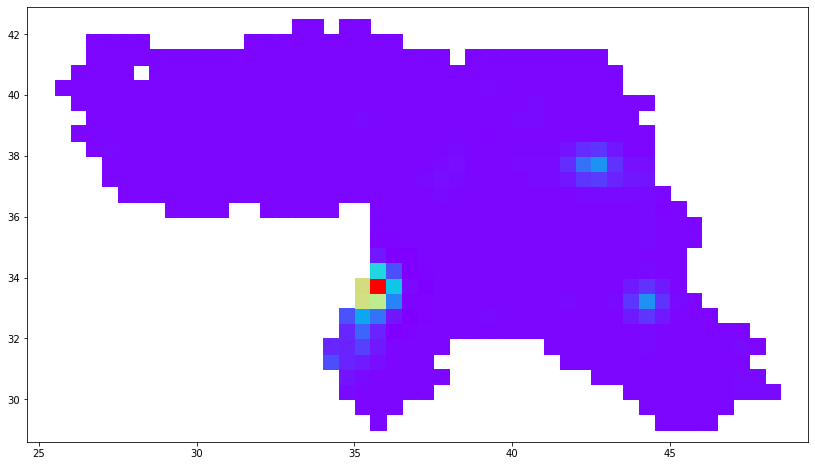

In [117]:
plt.figure(figsize = [14,8])
plt.scatter(X[:,0], X[:,1], c = mean_prediction_list[1], cmap = 'rainbow', marker = 's', s = 235)
plt.show()

In [100]:
mean_prediction_list[-1]

array([-1.50810491e-08,  3.35096876e-10,  6.13165020e-10,  7.92003533e-10,
       -2.01331523e-09,  2.41549208e-07,  7.01781495e-08,  1.82161460e-09,
       -8.21521670e-10, -1.85735339e-09, -7.11163549e-09,  1.02101967e-09,
       -1.89944632e-08,  9.61289818e-08, -7.50841912e-07, -2.20542852e-06,
       -3.32276943e-07,  2.61064936e-08,  4.94616455e-09, -2.12102174e-09,
        2.95707103e-09,  6.36669287e-09,  6.15543326e-09,  5.99075153e-08,
        8.92029301e-09, -4.43993769e-08,  4.05525619e-07,  9.59174013e-03,
        8.40491869e-03,  3.95103570e-06, -5.69512584e-04,  1.50018167e-05,
        7.75668009e-07, -5.09594535e-07,  1.06005549e-07, -1.74813987e-08,
        3.80408989e-09,  1.88873836e-10,  1.26170070e-09, -1.50925602e-08,
       -8.07510473e-08,  4.30301878e-08,  1.26339426e-03,  5.96008129e-08,
       -4.06492990e-08, -3.44623195e-05,  9.30869369e-07,  9.43382765e-03,
        1.32137012e+00,  8.68859401e-05,  4.50860832e-01,  2.31663792e-05,
       -3.41609631e-06,  

In [32]:
df_month = df_sub[df_sub['month_id'] == 323]

In [68]:
df_month = df_sub[df_sub['month_id'].isin([322, 323])].copy()
df_month.sort_values(['gid', 'month_id'], inplace = True) #needs for reshape to be correct

In [88]:
n_month = 2

y = np.array(df_month['tce']).reshape(-1,n_month)
X = np.array(df_month[['xcoord', 'ycoord']]).reshape(-1,2,n_month)

In [89]:
y.shape

(663, 2)

In [90]:
X.shape

(663, 2, 2)

In [91]:
noise_std = y.std()

kernel = ConstantKernel() * Matern(length_scale=4.0, length_scale_bounds=(0.1, 8.0), nu=1.5) + WhiteKernel(noise_level=noise_std)

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X, y)
gaussian_process.kernel_

ValueError: Found array with dim 3. GaussianProcessRegressor expected <= 2.

In [37]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

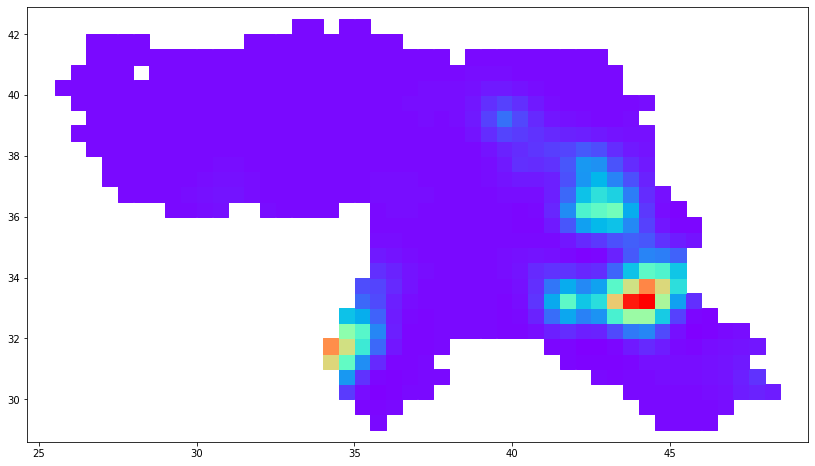

In [60]:
plt.figure(figsize = [14,8])
plt.scatter(X[:,0], X[:,1], c = mean_prediction, cmap = 'rainbow', marker = 's', s = 235)
plt.show()

In [ ]:
for i in sorted(df_sub['month_id'].unique())[180:215]:

    print(f"{i}: {df_sub[df_sub['month_id'] == i]['year_months_start'].unique().item()}")

    fig, ax = plt.subplots(figsize = (20,20))

    ax.set_aspect('equal')

    #vmax = combined_df['log_best'].max()
    vmax = df_sub.loc[(df_sub['gwno'].isin(gwno_to_keep)) & (df_sub['month_id'].isin(np.arange(180, 185+1, 1))), 'log_best'].max()

    df_sub[(df_sub['gwno'].isin(gwno_to_keep)) & (df_sub['month_id'] == i)].plot(ax = ax, column = 'tce', cmap = 'rainbow', vmin = 0, vmax = vmax)
    sub_world.plot(facecolor='none', edgecolor='black', ax=ax)
    plt.show()

In [ ]:
    test_gids = df_sub.loc[df_sub['log_best'] > 6, 'gid'].unique()
    n_timelines = test_gids.shape[0]

    print(f'number of timelines used: {n_timelines}')

    mask = df_sub['gid'].isin(test_gids)
    df_test2 = df_sub[mask].copy()
    df_test2.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work

    y = np.array(df_test2['log_best']).reshape(-1, n_timelines)
    x = np.array(df_test2[['month_id']]).reshape(-1, n_timelines)

    # GP
    noise_std = y.std()

    kernel_short = ConstantKernel() * Matern(length_scale=4.0, length_scale_bounds=(1, 32.0), nu=1.5) # nu = 1.5 gives v = 3/2 so matern32
    kernel_long = ConstantKernel() * RBF(length_scale=20.0, length_scale_bounds=(32, 320))

    kernel =  kernel_short + kernel_long + WhiteKernel(noise_level=noise_std)

    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    gaussian_process.fit(x, y)
    gaussian_process.kernel_

    return gaussian_process.kernel_